In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Data/Prices/MAINE.csv", header=0, parse_dates=[0], index_col=[0], usecols=['date', 'energy'])
df

,energy
date,
2017-01-01 00:00:00,34.86
2017-01-01 01:00:00,33.72
2017-01-01 02:00:00,32.40
2017-01-01 03:00:00,25.88
2017-01-01 04:00:00,29.65
...,...
2023-12-31 19:00:00,33.34
2023-12-31 20:00:00,34.53
2023-12-31 21:00:00,32.16


In [3]:
df.index = pd.DatetimeIndex(df.index).to_period('h')

<Axes: xlabel='date'>

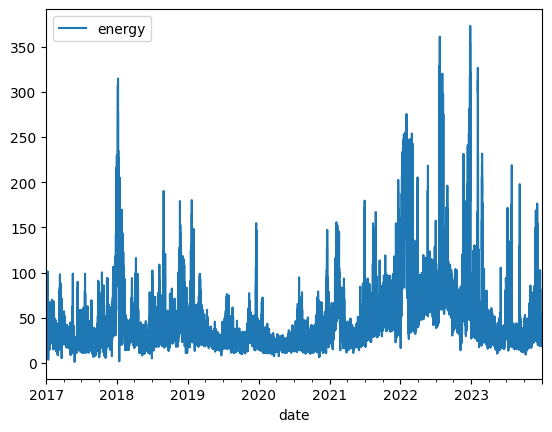

In [4]:
df.plot()

In [7]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 58.7 MB/s eta 0:00:0031m42.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 58.8 MB/s eta 0:00:00


# Train/Test Split
We will split by only testing the last week of the dataset (7 * 24 = 168).

In [8]:
train, test = df.loc['2023-10-01': '2023-12-24'], df[-168:]

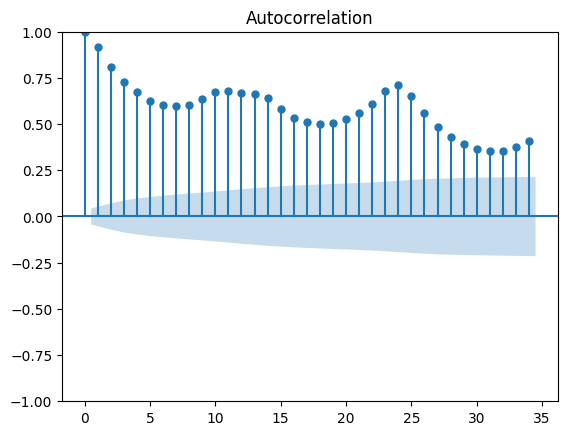

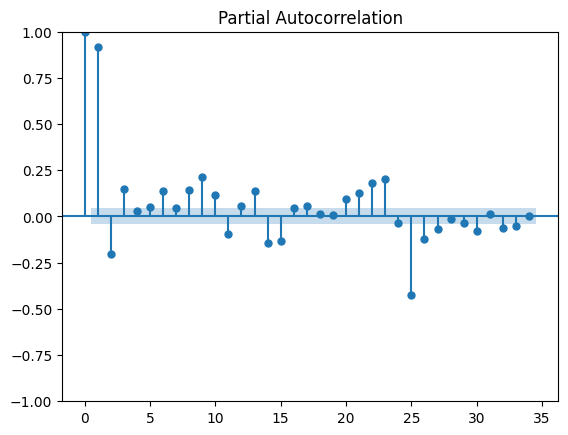

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(train)
pacf = plot_pacf(train)

In [10]:
from statsmodels.tsa.stattools import adfuller
adfuller(train)[1]

0.0005168217976855941

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['energy'], order=(2,0,1), seasonal_order=(2,0,1,24), enforce_invertibility=False)
model_fit = model.fit()

print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39340D+00    |proj g|=  4.52825D-01

At iterate    5    f=  3.26227D+00    |proj g|=  1.71660D+00

At iterate   10    f=  3.23859D+00    |proj g|=  2.13286D-01

At iterate   15    f=  3.20019D+00    |proj g|=  1.57047D-01

At iterate   20    f=  3.19906D+00    |proj g|=  1.60367D-01

At iterate   25    f=  3.18955D+00    |proj g|=  2.46458D-01

At iterate   30    f=  3.17427D+00    |proj g|=  1.14124D-01

At iterate   35    f=  3.17357D+00    |proj g|=  2.02157D-01

At iterate   40    f=  3.17203D+00    |proj g|=  2.69168D-01

At iterate   45    f=  3.16681D+00    |proj g|=  2.98186D-01

At iterate   50    f=  3.16529D+00    |proj g|=  2.28611D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alic/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             energy   No. Observations:                 2040
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 24)   Log Likelihood               -6457.190
Date:                            Fri, 03 May 2024   AIC                          12928.380
Time:                                    01:02:41   BIC                          12967.725
Sample:                                10-01-2023   HQIC                         12942.813
                                     - 12-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0901      0.011     -7.943      0.000      -0.112      -0.068
ar.L2          0.9083      0.010   

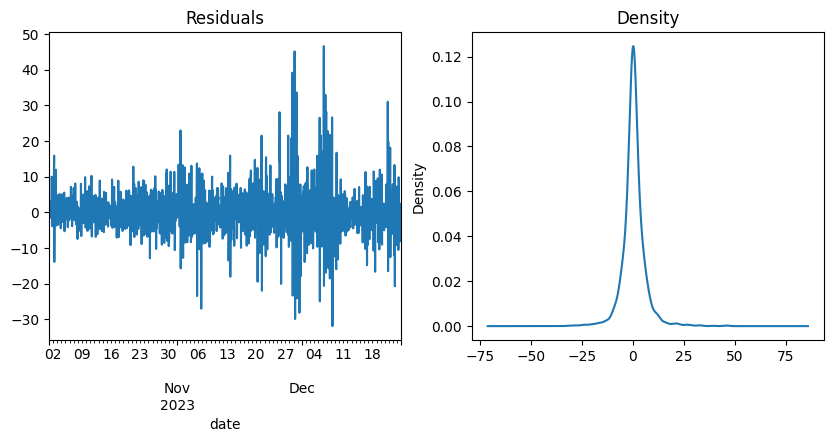

In [13]:
residuals = model_fit.resid[1:]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])

plt.show()

In [15]:
forecast = model_fit.forecast(test.shape[0])

test['Forecast'] = forecast.to_numpy()

/tmp/ipykernel_5031/1955814001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = forecast.to_numpy()


In [16]:
test = test.rename(columns={'energy': 'Actual'})


In [18]:
test

,Actual,Forecast
date,,
2023-12-25 00:00,23.33,21.761945
2023-12-25 01:00,21.40,19.818844
2023-12-25 02:00,20.24,18.453259
2023-12-25 03:00,19.71,19.023432
2023-12-25 04:00,20.26,20.633808
...,...,...
2023-12-31 19:00,33.34,38.298547
2023-12-31 20:00,34.53,36.932367
2023-12-31 21:00,32.16,35.158531


In [33]:
plot_test = test.loc['2023-12-01':'2023-12-31']

plot_test = plot_test.reset_index()
plot_test = plot_test.drop(columns=['date'])
plot_test

,Actual,Forecast
0,23.33,21.761945
1,21.40,19.818844
2,20.24,18.453259
3,19.71,19.023432
4,20.26,20.633808
...,...,...
163,33.34,38.298547
164,34.53,36.932367
165,32.16,35.158531
166,27.93,31.457080


<Axes: >

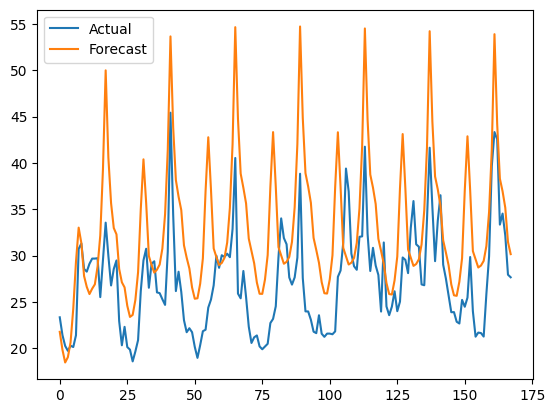

In [34]:
plot_test.plot()

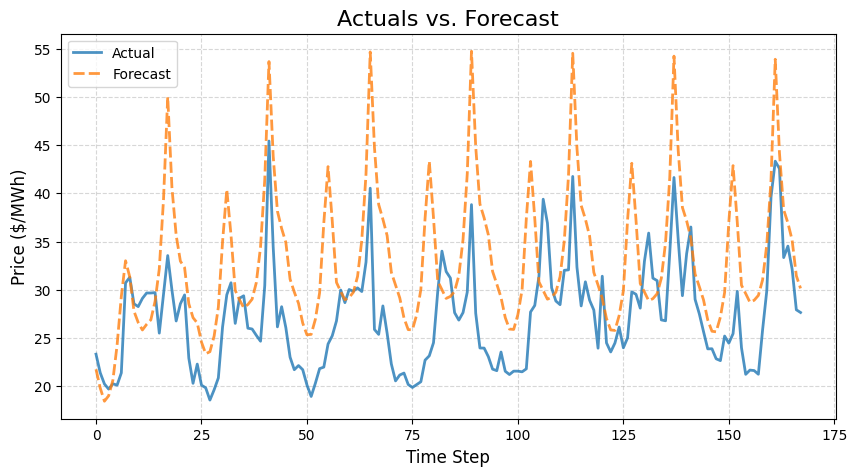

In [37]:
import seaborn as sns


# Create a figure with subplots
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Plot the data
sns.lineplot(data=plot_test, ax=axs, linewidth=2, alpha=0.8)
axs.set_title("Actuals vs. Forecast", fontsize=16)
axs.set_xlabel("Time Step", fontsize=12)
axs.set_ylabel("Price ($/MWh)", fontsize=12)
axs.grid(True, linestyle='--', alpha=0.5)

# Save the plot
plt.savefig('plot.png')